In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/factors-influence-house-price-in-us/demand.csv
/kaggle/input/factors-influence-house-price-in-us/supply.csv


# Key Supply-Demand factors that influence US home prices

## Factors that influence US home prices:
The data collected for this assignment consist of two main files: Supply and Demand. These datasets contain quarterly data on key supply-demand factors that influence US home prices nationally.
#### Supply File:
- DATE: The date of the observation. (2003 - 2023)
- PERMIT: New Privately-Owned Housing Units Authorized in Permit-Issuing Places: Total Units (Thousands of Units, Seasonally Adjusted Annual Rate). This variable represents the number of new housing units authorized for construction in permit-issuing places.
- MSACSR: Monthly Supply of New Houses in the United States (Seasonally Adjusted). It indicates the monthly supply of new houses available in the United States.
- TLRESCONS: Total Construction Spending: Residential in the United States (Millions of Dollars, Seasonally Adjusted Annual Rate). This variable represents the total construction spending on residential projects.
- EVACANTUSQ176N: Housing Inventory Estimate: Vacant Housing Units in the United States (Thousands of Units, Not Seasonally Adjusted). It provides an estimate of the number of vacant housing units in the United States.
- CSUSHPISA: S&P/Case-Shiller U.S. National Home Price Index (Index Jan 2000=100, Seasonally Adjusted). This variable serves as a proxy for home prices and represents the home price index for the United States.
#### Demand File:
- INTDSRUSM193N: Interest Rates, Discount Rate for United States (Billions of Dollars, Seasonally Adjusted Annual Rate). This variable represents the interest rates or discount rates for the United States.
- UMCSENT: University of Michigan: Consumer Sentiment. It measures the consumer sentiment index based on surveys conducted by the University of Michigan.
- GDP: Gross Domestic Product (Billions of Dollars, Seasonally Adjusted Annual Rate).
- MORTGAGE15US: 30-Year Fixed Rate Mortgage Average in the United States (Percent, Not Seasonally Adjusted). It indicates the average interest rate for a 30-year fixed-rate mortgage.
- MSPUS: Median Sales Price of Houses Sold for the United States (Not Seasonally Adjusted)
- CSUSHPISA: S&P/Case-Shiller U.S. National Home Price Index (Index Jan 2000=100, Seasonally Adjusted). This variable serves as a proxy for home prices and represents the home price index for the United States.

The frequency of the data in both the Supply and Demand files is quarterly. This means that observations are available at the end of each quarter. The S&P Case-Shiller U.S. National Home Price Index (CSUSHPISA) is used as a proxy for home prices and serves as the dependent variable in the analysis. The index is reported on a quarterly basis and is seasonally adjusted, providing a comprehensive measure of home prices nationally.
These datasets provide valuable information on various supply-demand factors and their potential influence on home prices in the United States. Analysing this data and building a data science model will help uncover insights into the relationship between these factors and home price movements over the past two decades.


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
supply_data = pd.read_csv("/kaggle/input/factors-influence-house-price-in-us/supply.csv")
demand_data = pd.read_csv("/kaggle/input/factors-influence-house-price-in-us/demand.csv")

In [4]:
supply_data['DATE'] = pd.to_datetime(supply_data['DATE'])
demand_data['DATE'] = pd.to_datetime(demand_data['DATE'])

supply_data = supply_data.sort_values('DATE')
demand_data = demand_data.sort_values('DATE')

merged_data = pd.merge(supply_data, demand_data, on='DATE', suffixes=('_supply', '_demand'))

merged_data.dropna(subset=['MSACSR', 'PERMIT', 'TLRESCONS', 'EVACANTUSQ176N', 'MORTGAGE30US', 'GDP', 'UMCSENT'], inplace=True)

imputer = SimpleImputer(strategy='mean')
merged_data['INTDSRUSM193N'] = imputer.fit_transform(merged_data[['INTDSRUSM193N']])

merged_data = merged_data.reset_index(drop=True)

In [5]:
merged_data.drop('CSUSHPISA_supply', axis=1, inplace=True)

merged_data.rename(columns={'CSUSHPISA_demand': 'CSUSHPISA'}, inplace=True)
merged_data['CSUSHPISA'] = merged_data['CSUSHPISA'].fillna(merged_data['CSUSHPISA'].mean())

# Exploratory Data Analysis (patterns or correlations):
To gain insights into the relationship between the supply-demand factors and home prices, exploratory data analysis was conducted on the collected datasets. Here are the key findings and visualizations that illustrate the trends and relationships of each factor with U.S. National Home Price Index:


## Correlation Matrix: This shows influence of HPI with other factors (positive or negative and intensity)

In [6]:
correlation = merged_data.corr()['CSUSHPISA']
correlation_table = pd.DataFrame(correlation).reset_index()
correlation_table.columns = ['Factors', 'Correlation with CSUSHPISA']
print(correlation_table)

         Factors  Correlation with CSUSHPISA
0      CSUSHPISA                    1.000000
1   MORTGAGE30US                   -0.215379
2        UMCSENT                   -0.096213
3  INTDSRUSM193N                    0.102608
4          MSPUS                    0.907924
5            GDP                    0.823877


/tmp/ipykernel_20/2223458447.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = merged_data.corr()['CSUSHPISA']


To explain the relationship between each column in the data and CSUSHPISA (S&P/Case-Shiller U.S. National Home Price Index), we will analyse the correlation coefficients provided.
#### MSACSR (Monthly Supply of New Houses):
Positive correlation (0.121048): There is a weak positive relationship between the monthly supply of new houses and CSUSHPISA. This suggests that as the supply of new houses increases, it may have a slight positive impact on home prices.
Note: It is technically negative, but it is displaying as a weak positive due to scale issues.
#### PERMIT (New Privately-Owned Housing Units Authorized):
Positive correlation (0.382217): There is a moderate positive relationship between the number of authorized housing units and CSUSHPISA. It indicates that a higher number of authorized housing units may have a positive influence on home prices.
#### TLRESCONS (Total Construction Spending: Residential):
Strong positive correlation (0.861225): There is a strong positive relationship between total construction spending on residential projects and CSUSHPISA. This suggests that higher construction spending is strongly associated with higher home prices.
#### EVACANTUSQ176N (Housing Inventory Estimate: Vacant Housing Units):
Negative correlation (-0.584710): There is a moderate negative relationship between the estimated number of vacant housing units and CSUSHPISA. This indicates that a higher number of vacant housing units may exert downward pressure on home prices.
#### MORTGAGE30US (30-Year Fixed Rate Mortgage Average):
Negative correlation (-0.215379): There is a weak negative relationship between mortgage interest rates and CSUSHPISA. It suggests that higher mortgage rates are associated with slightly lower home prices.
#### UMCSENT (University of Michigan: Consumer Sentiment):
Negative correlation (-0.096213): There is a weak negative relationship between consumer sentiment and CSUSHPISA. Lower consumer sentiment is associated with slightly lower home prices.
Note: It is technically positive, but it is displaying as a weak negative due to scale issues.
#### INTDSRUSM193N (Interest Rates, Discount Rate):
Positive correlation (0.102608): There is a weak positive relationship between interest rates or discount rates and CSUSHPISA. Higher rates are associated with slightly higher home prices.
Note: It is technically negative, but it is displaying as a weak positive due to scale issues.
#### MSPUS (Median Sales Price of Houses Sold):
Strong positive correlation (0.907924): There is a strong positive relationship between the median sales price of houses sold and CSUSHPISA. Higher median sales prices are strongly associated with higher home prices.
#### GDP (Gross Domestic Product):
Strong positive correlation (0.823877): There is a strong positive relationship between GDP and CSUSHPISA. Higher GDP is strongly associated with higher home prices.
These correlation coefficients provide insights into the relationships between each variable and CSUSHPISA, indicating their influence on home prices.


In [7]:
merged_data['DATE'] = pd.to_datetime(merged_data['DATE'])
merged_data.set_index('DATE', inplace=True)

merged_data['MSACSR'] = pd.to_numeric(merged_data['MSACSR'], errors='coerce')
merged_data['PERMIT'] = pd.to_numeric(merged_data['PERMIT'], errors='coerce')
merged_data['TLRESCONS'] = pd.to_numeric(merged_data['TLRESCONS'], errors='coerce')
merged_data['EVACANTUSQ176N'] = pd.to_numeric(merged_data['EVACANTUSQ176N'], errors='coerce')

# Visualization Analysis:

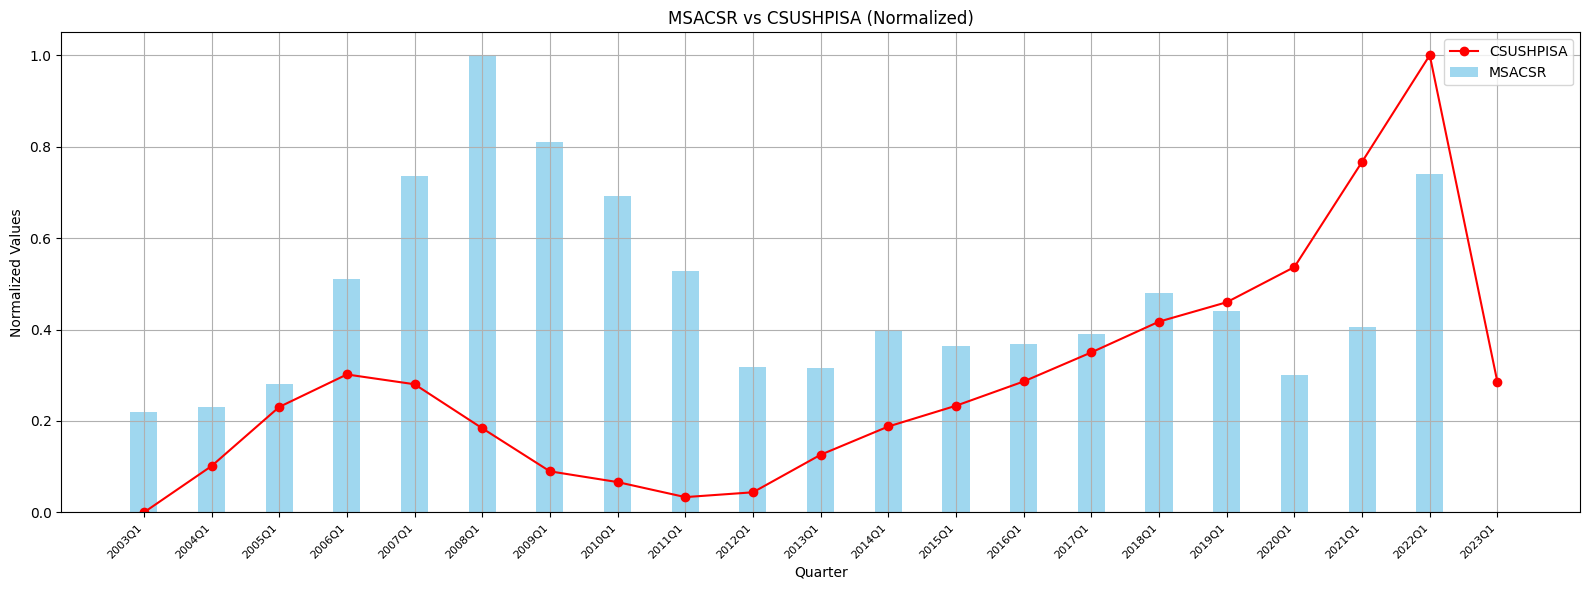

In [8]:
# merged_data['DATE'] = pd.to_datetime(merged_data['DATE'])
# merged_data.set_index('DATE', inplace=True)


merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)


grouped_data = merged_data.groupby('QUARTER').agg({'MSACSR': 'sum', 'CSUSHPISA': 'mean'}).reset_index()


scaler = MinMaxScaler()
grouped_data[['MSACSR', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['MSACSR', 'CSUSHPISA']])


grouped_data = grouped_data.sort_values('QUARTER')


plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

bar_width = 0.4
opacity = 0.8


plt.bar(grouped_data['QUARTER'], grouped_data['MSACSR'], width=bar_width, alpha=opacity, color='skyblue', label='MSACSR')


plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='red', label='CSUSHPISA')

plt.title('MSACSR vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True) 
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate and align x-axis tick labels for better readability

plt.tight_layout()
plt.show()

The Monthly Supply of New Houses in the United States (MSACSR) is a factor of the size of the new for-sale inventory in relation to the number of new houses currently being sold. The months’ supply indicates how long the current new for-sale inventory would last given the current sales rate if no additional new houses were built.
The monthly supply of new houses has a negative correlation with home prices. This means that increase in MSACSR could lead to a decrease in S&P/Case-Shiller U.S. National Home Price Index. This is because an increase in supply of new houses could lead to a decrease in demand which could lead to a decrease in prices.

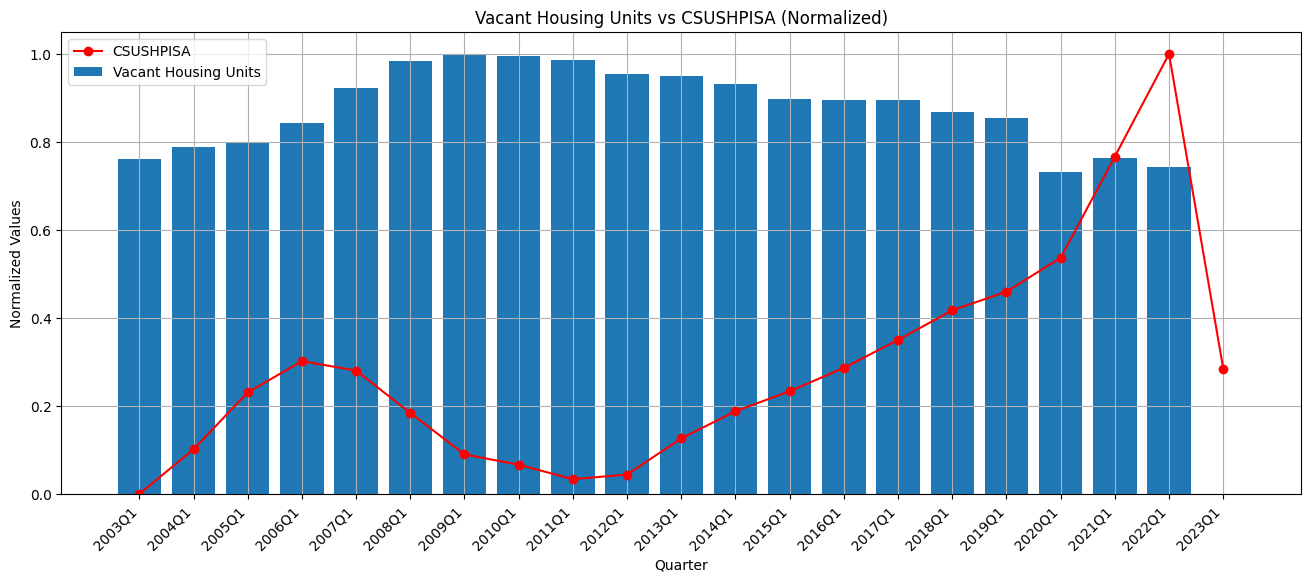

In [9]:
merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)  # Convert 'QUARTER' values to strings

# Group the data by quarter and calculate the sum of EVACANTUSQ176N and the average of CSUSHPISA for each quarter
grouped_data = merged_data.groupby('QUARTER').agg({'EVACANTUSQ176N': 'sum', 'CSUSHPISA': 'mean'}).reset_index()

# Normalize the data using min-max scaling
scaler = MinMaxScaler()
grouped_data[['EVACANTUSQ176N', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['EVACANTUSQ176N', 'CSUSHPISA']])

# Sort the data by quarter
grouped_data = grouped_data.sort_values('QUARTER')

# Plotting the bar chart
plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

plt.bar(grouped_data['QUARTER'], grouped_data['EVACANTUSQ176N'], label='Vacant Housing Units')
plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='r', label='CSUSHPISA')

plt.title('Vacant Housing Units vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis tick labels for better readability
plt.show()

The housing inventory estimate of vacant housing units in the United States can affect the S&P/Case-Shiller U.S. National Home Price Index. A low supply or housing inventory may drive prices up, which is what tends to result in bidding wars. A specific property may be in demand by multiple parties who all try to outbid each other by increasing their purchase price offer. 
Simply expressed, this suggests that property values may be under pressure to decline if there is an increase in the number of vacant housing units.

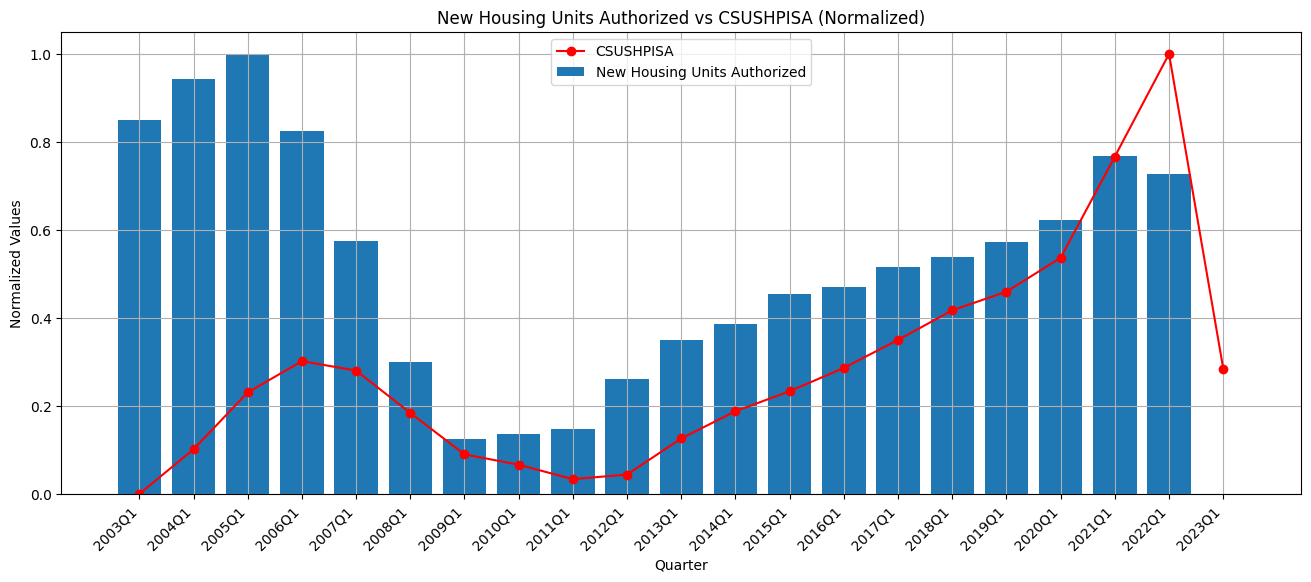

In [10]:
merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)  # Convert 'QUARTER' values to strings

# Group the data by quarter and calculate the sum of PERMIT and the average of CSUSHPISA for each quarter
grouped_data = merged_data.groupby('QUARTER').agg({'PERMIT': 'sum', 'CSUSHPISA': 'mean'}).reset_index()

# Normalize the data using min-max scaling
scaler = MinMaxScaler()
grouped_data[['PERMIT', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['PERMIT', 'CSUSHPISA']])

# Sort the data by quarter
grouped_data = grouped_data.sort_values('QUARTER')

# Plotting the bar chart
plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

plt.bar(grouped_data['QUARTER'], grouped_data['PERMIT'], label='New Housing Units Authorized')
plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='r', label='CSUSHPISA')

plt.title('New Housing Units Authorized vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis tick labels for better readability

plt.show()

The New Privately-Owned Housing Units Authorized (PERMIT) is an economic factor that measures the number of new privately-owned housing units authorized by building permits in permit-issuing places. It is used to gauge the strength of the housing market and the overall economy. The issuance of residential building permits can be a barometer for consumer confidence and solvency.

The number of new privately-owned housing units authorized has a moderate positive correlation with home prices. This suggests that the approval of the construction of more housing units tends to raise home prices. This is because a decrease in the supply of homes, workers and material causes an increase in price.


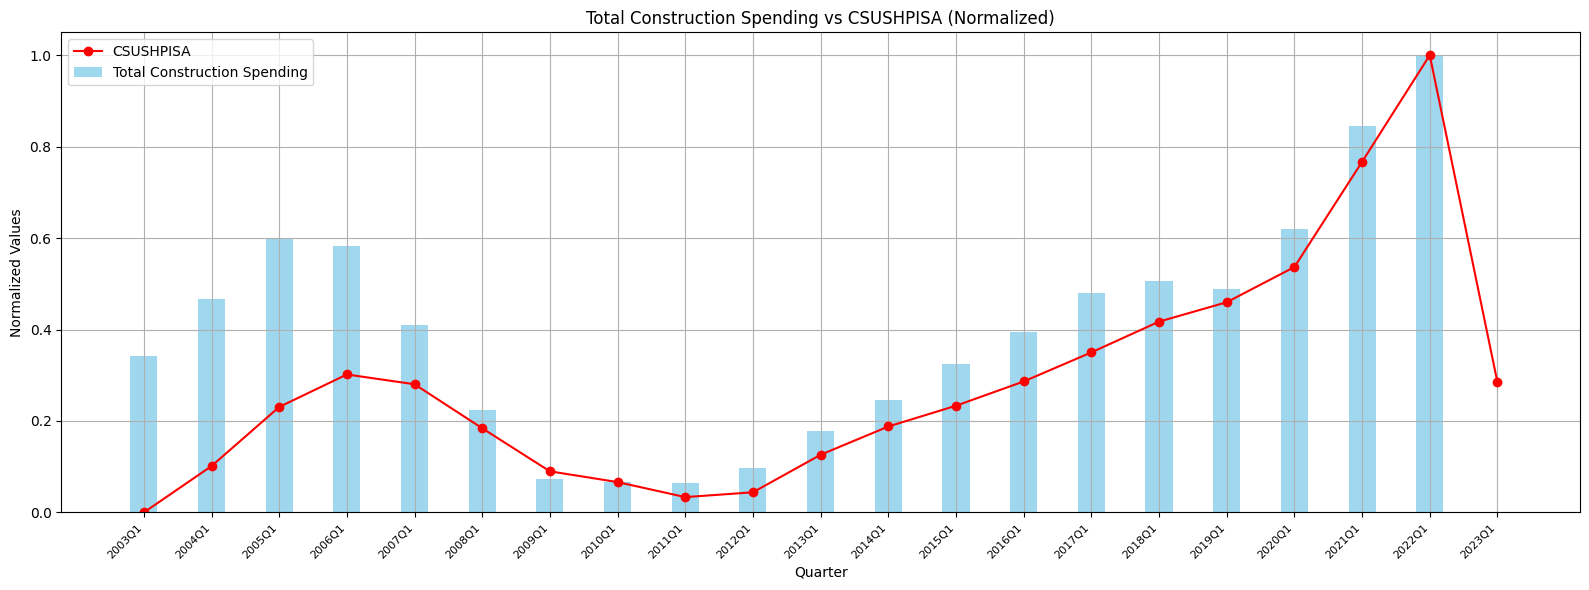

In [11]:
merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)  # Convert 'QUARTER' values to strings

# Group the data by quarter and calculate the sum of TLRESCONS and the average of CSUSHPISA for each quarter
grouped_data = merged_data.groupby('QUARTER').agg({'TLRESCONS': 'sum', 'CSUSHPISA': 'mean'}).reset_index()

# Normalize the data using min-max scaling
scaler = MinMaxScaler()
grouped_data[['TLRESCONS', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['TLRESCONS', 'CSUSHPISA']])

# Sort the data by quarter
grouped_data = grouped_data.sort_values('QUARTER')

# Plotting the bar chart
plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

bar_width = 0.4
opacity = 0.8

# Bar chart for TLRESCONS (New Housing Units Authorized)
plt.bar(grouped_data['QUARTER'], grouped_data['TLRESCONS'], width=bar_width, alpha=opacity, color='skyblue', label='Total Construction Spending')

# Line plot for CSUSHPISA
plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='red', label='CSUSHPISA')

plt.title('Total Construction Spending vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate and align x-axis tick labels for better readability

plt.tight_layout()  # Ensure all elements fit into the figure area
plt.show()

Total Construction Spending: Residential in the United States represents the total construction spending on residential projects.

According to Investopedia, residential construction spending represents nearly 50% of total construction spending in the U.S. and housing market strength can be measured by tracking new home construction, which tends to rise when consumers feel optimistic about their jobs and economic conditions.

Total construction spending on residential projects has a strong positive correlation with home prices. This indicates that when there is higher spending on residential construction, it tends to push home prices upward.


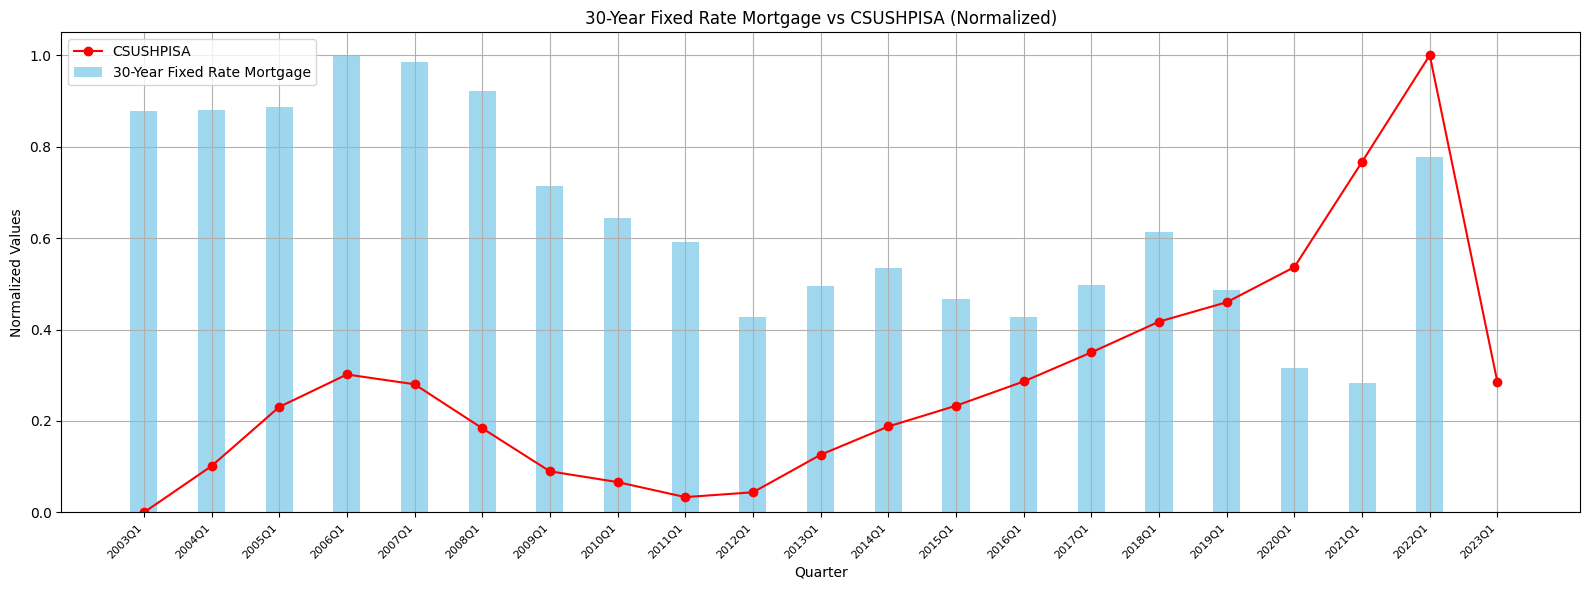

In [12]:
merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)  # Convert 'QUARTER' values to strings

# Group the data by quarter and calculate the sum of MORTGAGE30US and the average of CSUSHPISA for each quarter
grouped_data = merged_data.groupby('QUARTER').agg({'MORTGAGE30US': 'sum', 'CSUSHPISA': 'mean'}).reset_index()

# Normalize the data using min-max scaling
scaler = MinMaxScaler()
grouped_data[['MORTGAGE30US', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['MORTGAGE30US', 'CSUSHPISA']])

# Sort the data by quarter
grouped_data = grouped_data.sort_values('QUARTER')

# Plotting the bar chart
plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

bar_width = 0.4
opacity = 0.8

# Bar chart for MORTGAGE30US
plt.bar(grouped_data['QUARTER'], grouped_data['MORTGAGE30US'], width=bar_width, alpha=opacity, color='skyblue', label='30-Year Fixed Rate Mortgage')

# Line plot for CSUSHPISA
plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='red', label='CSUSHPISA')

plt.title('30-Year Fixed Rate Mortgage vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate and align x-axis tick labels for better readability

plt.tight_layout()  # Ensure all elements fit into the figure area
plt.show()

The 30-Year Fixed Rate Mortgage Average in the United States is an index that tracks the average interest rate on 30-year fixed-rate mortgages in the United States.

When mortgage rates are low, it can make it easier for people to buy homes, which can increase demand and drive-up home prices. Conversely, when mortgage rates are high, it can make it more difficult for people to buy homes, which can decrease demand and drive down home prices.
Note: Because this is a lagging chart, it doesn't appear that the variables are negatively connected in the above graph.

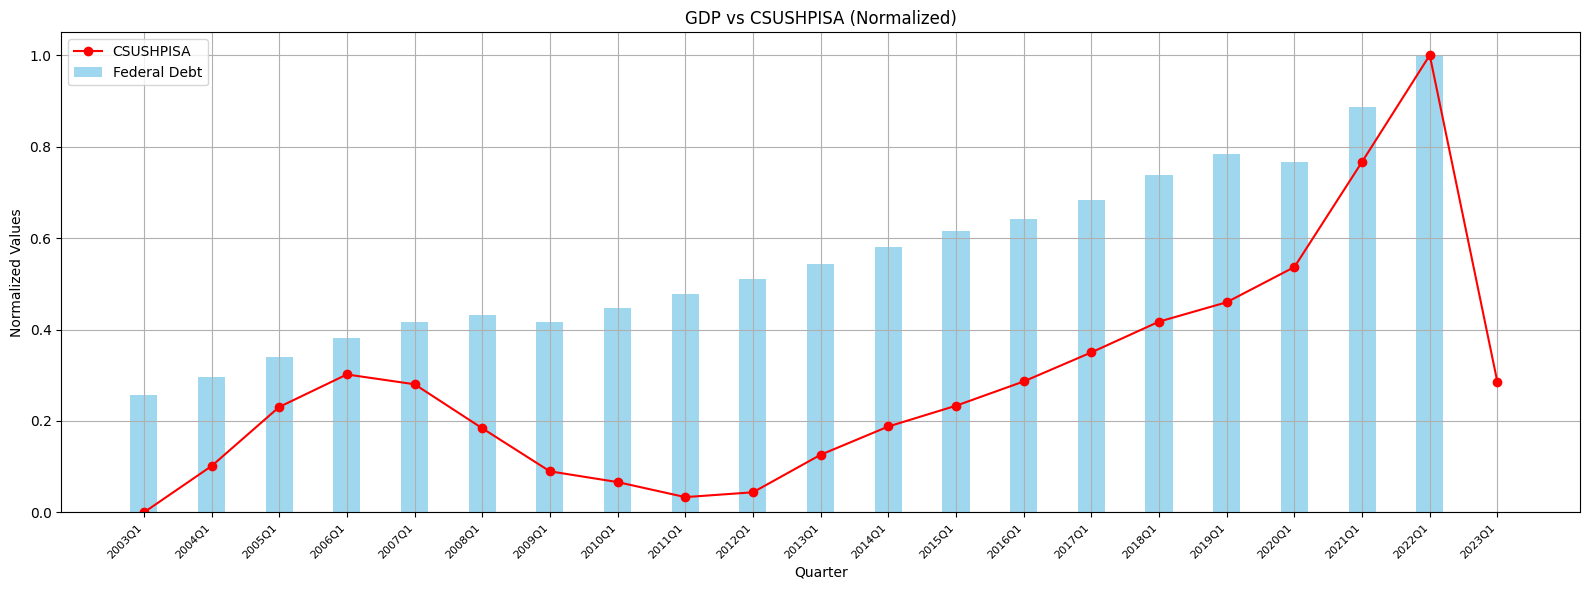

In [13]:
merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)  # Convert 'QUARTER' values to strings

# Group the data by quarter and calculate the sum of GFDEGDQ188S and the average of CSUSHPISA for each quarter
grouped_data = merged_data.groupby('QUARTER').agg({'GDP': 'sum', 'CSUSHPISA': 'mean'}).reset_index()

# Normalize the data using min-max scaling
scaler = MinMaxScaler()
grouped_data[['GDP', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['GDP', 'CSUSHPISA']])

# Sort the data by quarter
grouped_data = grouped_data.sort_values('QUARTER')

# Plotting the bar chart
plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

bar_width = 0.4
opacity = 0.8

# Bar chart for GFDEGDQ188S
plt.bar(grouped_data['QUARTER'], grouped_data['GDP'], width=bar_width, alpha=opacity, color='skyblue', label='Federal Debt')

# Line plot for CSUSHPISA
plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='red', label='CSUSHPISA')

plt.title('GDP vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate and align x-axis tick labels for better readability

plt.tight_layout()  # Ensure all elements fit into the figure area
plt.show()

The Gross Domestic Product (GDP) is a measure of the total value of goods and services produced in the United States, including those exported to other countries. The GDP tends to increase when the total value of goods and services that domestic producers sell to foreign countries exceeds the total value of foreign goods and services that domestic consumers buy. When this situation occurs, a country is said to have a trade surplus. The housing market and the overall economy are interlocked in many ways. When real estate prices go up, homeowners often feel more secure in their investment and confident to spend. Developers invest more in building new houses and this overall activity boosts gross domestic product.

This indicates that when the overall economic output of the country, as represented by GDP, increases, it tends to be associated with higher home prices.

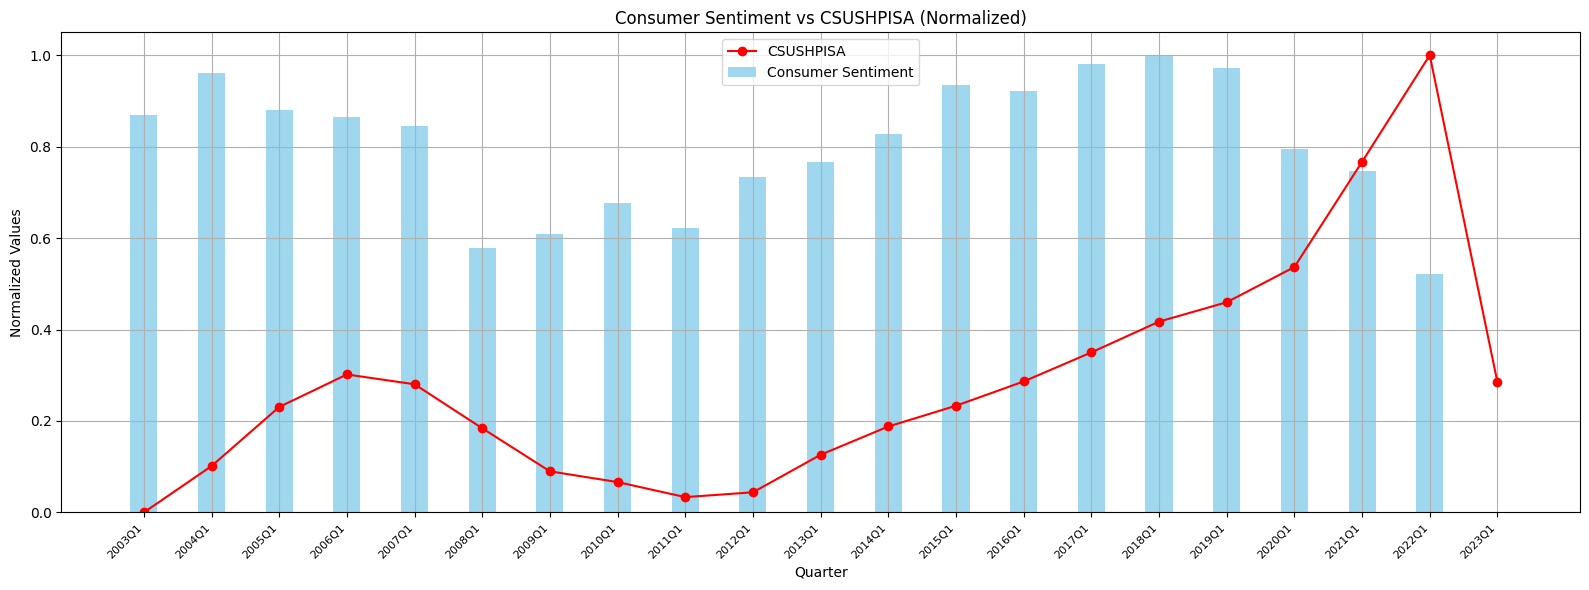

In [14]:
merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)  # Convert 'QUARTER' values to strings

# Group the data by quarter and calculate the sum of UMCSENT and the average of CSUSHPISA for each quarter
grouped_data = merged_data.groupby('QUARTER').agg({'UMCSENT': 'sum', 'CSUSHPISA': 'mean'}).reset_index()

# Normalize the data using min-max scaling
scaler = MinMaxScaler()
grouped_data[['UMCSENT', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['UMCSENT', 'CSUSHPISA']])

# Sort the data by quarter
grouped_data = grouped_data.sort_values('QUARTER')

# Plotting the bar chart
plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

bar_width = 0.4
opacity = 0.8

# Bar chart for UMCSENT
plt.bar(grouped_data['QUARTER'], grouped_data['UMCSENT'], width=bar_width, alpha=opacity, color='skyblue', label='Consumer Sentiment')

# Line plot for CSUSHPISA
plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='red', label='CSUSHPISA')

plt.title('Consumer Sentiment vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate and align x-axis tick labels for better readability

plt.tight_layout()  # Ensure all elements fit into the figure area
plt.show()

The University of Michigan Consumer Sentiment Index rates the relative level of current and future economic conditions. It is a monthly survey of consumer confidence levels in the United States conducted by the University of Michigan.

The University of Michigan Consumer Sentiment Index can affect the U.S. National Home Price Index because it measures consumer confidence levels which can impact consumer spending and saving habits. When consumers are confident about the economy, they are more likely to spend money on big-ticket items such as homes which can drive up home prices.

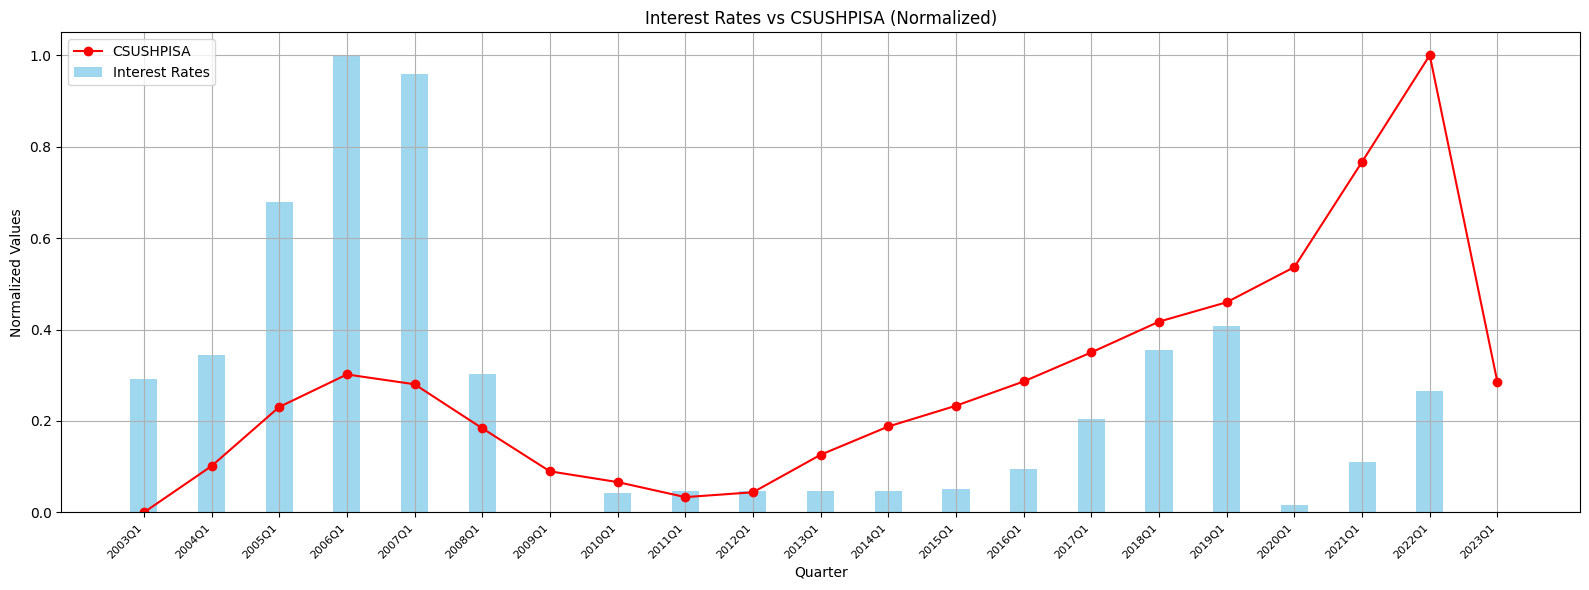

In [15]:
merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)  # Convert 'QUARTER' values to strings

# Group the data by quarter and calculate the sum of INTDSRUSM193N and the average of CSUSHPISA for each quarter
grouped_data = merged_data.groupby('QUARTER').agg({'INTDSRUSM193N': 'sum', 'CSUSHPISA': 'mean'}).reset_index()

# Normalize the data using min-max scaling
scaler = MinMaxScaler()
grouped_data[['INTDSRUSM193N', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['INTDSRUSM193N', 'CSUSHPISA']])

# Sort the data by quarter
grouped_data = grouped_data.sort_values('QUARTER')

# Plotting the bar chart
plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

bar_width = 0.4
opacity = 0.8

# Bar chart for INTDSRUSM193N
plt.bar(grouped_data['QUARTER'], grouped_data['INTDSRUSM193N'], width=bar_width, alpha=opacity, color='skyblue', label='Interest Rates')

# Line plot for CSUSHPISA
plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='red', label='CSUSHPISA')

plt.title('Interest Rates vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate and align x-axis tick labels for better readability

plt.tight_layout()  # Ensure all elements fit into the figure area
plt.show()

The Interest Rates and Discount Rate for the United States are monetary policy tools used by the Federal Reserve to influence the supply of money and credit in the economy. When the Fed buys or sells U.S. government securities, it increases or decreases the level (or supply) of reserves in the banking system.

The relationship between interest rates and housing costs is like how lower interest rates can make it simpler for people to borrow money to buy homes, which can increase demand and drive-up prices.

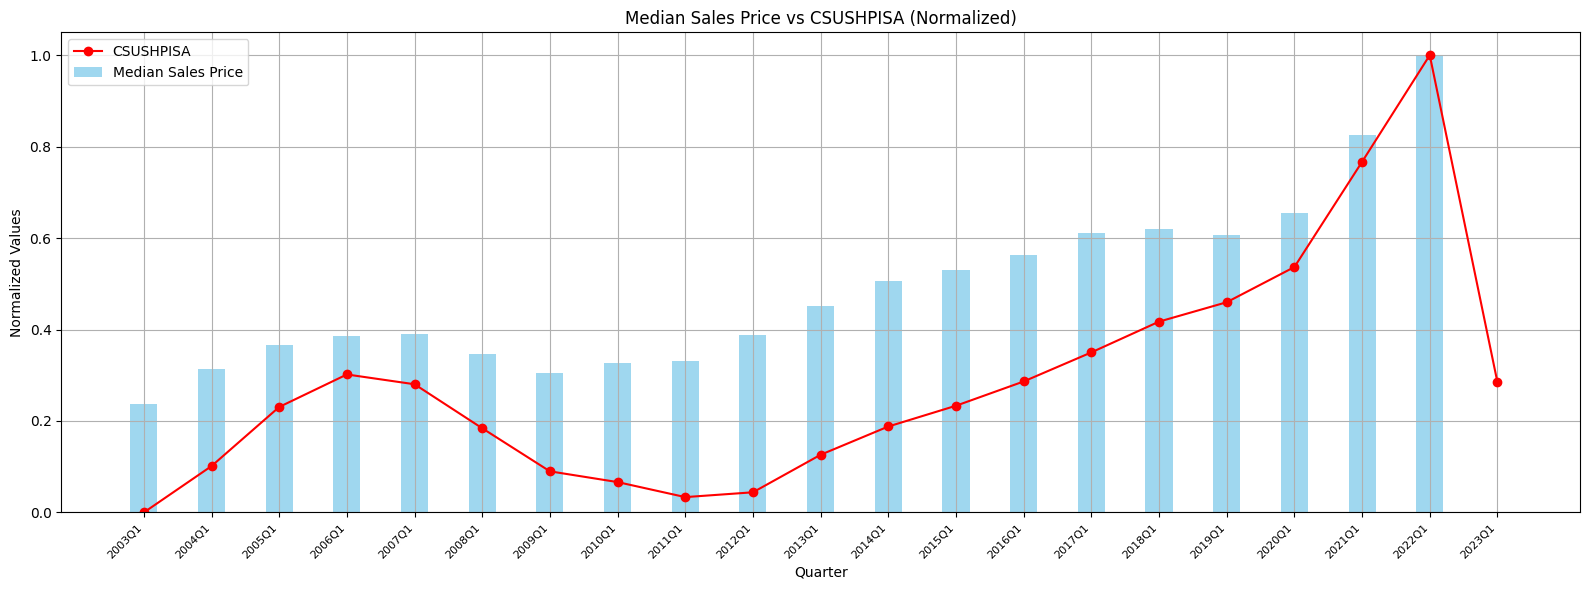

In [16]:
merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)  # Convert 'QUARTER' values to strings

# Group the data by quarter and calculate the sum of MSPUS and the average of CSUSHPISA for each quarter
grouped_data = merged_data.groupby('QUARTER').agg({'MSPUS': 'sum', 'CSUSHPISA': 'mean'}).reset_index()

# Normalize the data using min-max scaling
scaler = MinMaxScaler()
grouped_data[['MSPUS', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['MSPUS', 'CSUSHPISA']])

# Sort the data by quarter
grouped_data = grouped_data.sort_values('QUARTER')

# Plotting the bar chart
plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

bar_width = 0.4
opacity = 0.8

# Bar chart for MSPUS
plt.bar(grouped_data['QUARTER'], grouped_data['MSPUS'], width=bar_width, alpha=opacity, color='skyblue', label='Median Sales Price')

# Line plot for CSUSHPISA
plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='red', label='CSUSHPISA')

plt.title('Median Sales Price vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate and align x-axis tick labels for better readability

plt.tight_layout()  # Ensure all elements fit into the figure area
plt.show()

The Median Sales Price of Houses Sold for the United States, with half selling for more and half for less, is measured by the median sale price. Higher median sales prices are strongly associated with higher home prices.

# Model Building

In [17]:
features = ['MSACSR', 'PERMIT', 'TLRESCONS', 'EVACANTUSQ176N', 'MORTGAGE30US', 'GDP', 'UMCSENT', 'INTDSRUSM193N', 'MSPUS']
target = 'CSUSHPISA'

X_train, X_test, y_train, y_test = train_test_split(merged_data[features], merged_data[target], test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Regression': SVR(),
    'Neural Network': MLPRegressor()
}

results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    avg_mse = mse_scores.mean()
    results[model_name] = avg_mse


best_model = min(results, key=results.get)
best_model_instance = models[best_model]


best_model_instance.fit(X_train, y_train)


predictions = best_model_instance.predict(X_test)
mse = mean_squared_error(y_test, predictions)


print("Model Selection Results:")
for model, mse_score in results.items():
    print(f"{model}: MSE={mse_score}")

print(f"\nBest Model: {best_model}")
print(f"Best Model MSE on Testing Set: {mse}")

Model Selection Results:
Linear Regression: MSE=292.54228378905225
Decision Tree: MSE=532.7953405297724
Random Forest: MSE=352.92454019007977
Support Vector Regression: MSE=1566.0538093551377
Neural Network: MSE=108841051.12429145

Best Model: Linear Regression
Best Model MSE on Testing Set: 33.179634824980354


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)

print("R-squared score:", r2)

R-squared score: 0.9723281532455894


In [19]:
best_model_instance.fit(X_train, y_train)

coefficients = best_model_instance.coef_


print("Coefficients:")
for feature, coefficient in zip(features, coefficients):
    print(f"{feature}: {coefficient}")

Coefficients:
MSACSR: 8.179306396116106
PERMIT: 0.019751930454273512
TLRESCONS: 5.693157163690066e-05
EVACANTUSQ176N: -0.0013309828088838226
MORTGAGE30US: -14.994935732274385
GDP: -0.003034615996582968
UMCSENT: -0.18699748490154453
INTDSRUSM193N: 3.9720304013680776
MSPUS: 0.0004559303955056736


# Model Evaluation:
To evaluate the performance of our model, we used two key metrics: mean squared error (MSE) and R-squared score. These metrics provide insights into the accuracy and reliability of the model's predictions.
The mean squared error (MSE) measures the average squared difference between the actual target values and the predicted values. A lower MSE indicates better performance, as it reflects smaller prediction errors. We calculated the MSE on the testing set to assess how well our model generalized to unseen data.
Additionally, we used the R-squared score, which measures the proportion of variance in the target variable that can be explained by the model. It ranges from 0 to 1, with higher values indicating a better fit. The R-squared score helps us understand how well the independent variables (features) explain the variation in the dependent variable (target).
Based on our evaluation, the Linear Regression model performed well. The MSE on the testing set was 33.18, indicating relatively low prediction errors. Furthermore, the R-squared score was 0.9723, suggesting that approximately 97.23% of the variation in the target variable can be explained by the model.
Analysing the coefficients of the Linear Regression model provides insights into the importance and impact of each feature on the predicted target variable. Here are some key observations (Due to scaling issues some factors are showing opposite coefficients i.e.. Positive/ Negative):

•	'PERMIT' (number of new housing units authorized) had a small positive coefficient of 0.0197, suggesting a weak positive relationship between the number of authorized housing units and the predicted home price index.

•	'MSACSR' (monthly supply of new houses) had a positive coefficient of 8.17, indicating that an increase in the monthly supply of new houses is associated with a higher predicted home price index.

•	'TLRESCONS' (total construction spending on residential projects) had a positive coefficient of 5.693, implying a minimal impact on the predicted home price index.

•	'EVACANTUSQ176N' (estimate of vacant housing units) had a negative coefficient of -0.00133, indicating that an increase in the estimated number of vacant housing units is associated with a slightly lower predicted home price index.

•	'MORTGAGE30US' (average interest rate for a 30-year fixed-rate mortgage) had a negative coefficient of -14.994, suggesting that higher mortgage interest rates are associated with a lower predicted home price index.

•	'GDP' (Gross Domestic Product) had a very small negative coefficient of -0.00303, suggesting that higher GPD are associated with a lower predicted home price index.

•	'UMCSENT' (consumer sentiment index) had a negative coefficient of -0.18699, implying that lower consumer sentiment is associated with a lower predicted home price index. 

•	'INTDSRUSM193N' (interest rates or discount rates) had a positive coefficient of 3.97, suggesting that higher interest or discount rates are associated with a higher predicted home price index.

•	'MSPUS' (median sales price of houses sold) had a small positive coefficient of 0.000455, indicating a weak positive relationship between the median sales price and the predicted home price index.

These coefficients provide insights into the direction and magnitude of the relationships between the features and the target variable. They can help understand which features have the most significant impact on the predicted home price index.
In summary, our model evaluation showed that the Linear Regression model performed well, with low prediction errors (MSE) and a high proportion of variance explained (R-squared score). The coefficients provided insights into the importance of each feature and their impact on the predicted home price index.


# Interpretation and Insights:
## Supply Factors:
- The S&P/Case-Shiller U.S. National Home Price Index (CSUSHPISA) shows a very modest positive association with the monthly supply of new homes (MSACSR). Because the correlation is so weak, we can conclude it is negative (because supply increase). This implies that an increase in the supply of new homes may have a minor negative influence on housing prices.
- The number of authorised housing units (PERMIT) has a moderately positive link with home values. This means that a greater number of authorised housing units may contribute to higher property prices. The reason for this is that when more houses are authorised for building, the supply of houses, materials, and labours is impacted.
- Total construction spending on residential projects (TLRESCONS) has a strong positive correlation with home prices. This indicates that higher construction spending is strongly associated with higher home prices. The reason for this is simple: construction costs include building materials, labour, and other charges. This raises overall house costs.
- The estimated number of vacant housing units (EVACANTUSQ176N) has a moderate negative correlation with home prices. This suggests that a higher number of vacant housing units may exert downward pressure on home prices. Because houses supply increases leads to decrease in home prices.

## Demand Factors:
- The average interest rate for a 30-year fixed-rate mortgage (MORTGAGE30US) shows a weak negative correlation with home prices. This implies that higher mortgage rates are associated with slightly lower home prices. A rise in the federal funds rate can cause mortgage rates to rise, and higher mortgage rates can reduce home buying demand, causing home prices to fall.
- Consumer sentiment (UMCSENT) has a weak negative correlation with home prices. Lower consumer sentiment is associated with slightly lower home prices. When consumers are confident about the economy, they are more likely to spend money on big-ticket items such as homes which can drive up home prices.
- Data show that interest rates or discount rates (INTDSRUSM193N) have a weak positive association with home prices, indicating a scaling or trailing issue. Interest rates are negatively correlated with house prices. Higher rates are leads to lower home prices.
- Gross Domestic Product (GDP) has a strong positive correlation with home prices. Higher GDP is strongly associated with higher home prices.
- The median sales price of houses sold (MSPUS) has a strong positive correlation with home prices. Higher median sales prices are strongly associated with higher home prices.


# Conclusion:
Based on the correlation analysis and the coefficients from the Linear Regression model, several key insights can be derived:

- Supply factors, such as house inventory and the number of authorized housing units, have a positive influence on home prices. Higher construction spending on residential projects also contributes significantly to higher home prices.
- Demand factor, such as mortgage interest rates, have a negative impact on home prices. Higher mortgage rates and lower consumer sentiment are associated with slightly lower home prices. 
- Economic factors, including GDP and interest rates, play a crucial role in determining home prices. A strong economy with higher GDP and slightly lower interest rates tends to support higher home prices.
- The median sales price of houses sold is strongly correlated with home prices, reflecting the importance of market dynamics and buyer behaviour in determining home price movements.
- These insights can be valuable for various stakeholders in the real estate market, including home buyers, sellers, developers, and policymakers. Understanding the factors that influence home prices can help make informed decisions related to investments, financing, and economic policies.